<a href="https://colab.research.google.com/github/jjablonski-it/pjatk-mhe/blob/main/MHE_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zaimplementuj GA dla Twojego zadania. Jest tu sporo elementów, dlatego dopuszczam częściowe rozwiązania i każde będę oceniał indywidualnie. Niech będzie:
	
- 2 metody krzyżowania
- 2 metody mutacji
- 2 warunki zakończenia

Parametrami niech będzie - wybór metody krzyżowania, mutacji oraz warunku zakończenia. Parametrem niech będzie także liczba osobników w populacji.

## GA:
- Population
- Fitness Calculation
- Mating Pool
- Parents Selection
- Mating -> Crossover/Mutation
- Offspring

In [1]:
import random
import math
import matplotlib.pyplot as plt

In [2]:
# constants
LENGTH = 100
VALUE_RANGE = 100000

In [3]:
data = [random.randint(-VALUE_RANGE,VALUE_RANGE) for _ in range(LENGTH)]
# data[0] = 0
print(0 in data)

False


In [4]:
# functions
def random_index():
  return ''.join(['%d' % random.randint(0,1) for _ in range(LENGTH)])

def index_to_set(index):
  result = []
  for i, x in enumerate(list(index)):
    if(x=='1'):
      result.append(i)
  return list(map(lambda x: data[x] ,result))

def subset_sum(index):
  return abs(sum(index_to_set(index)))

def negate_bit(index, n):
  index_list = list(index)
  bit = index_list[n]
  index_list[n] = '1' if bit=='0' else '0'
  return ''.join(index_list)

def generate_neighbours(index):
  return filter(lambda x: x != '0'*LENGTH, [negate_bit(index, x) for x in range(LENGTH)])

def get_best_index(indices):
  sum_dict = {index: subset_sum(index) for index in indices}
  return min(sum_dict, key=sum_dict.get)

def plot_indices_to_sum(indices):
    plt.plot(list(map(lambda x: subset_sum(x), indices)))

def bruteforce_lowest_sum(val=0):
  all_indices = list(map(lambda x: ("{:0"+str(LENGTH)+"b}").format(x), range(1,2**LENGTH)))
  print('generated all incides, testing...')
  best = subset_sum(all_indices[0])
  for x in all_indices:
    result = subset_sum(x)
    if(result <= val): 
      return result
    if(result < best): 
      best = result
  return best

In [5]:
class GA:
  def __init__(self, pop_size, mutation_rate, cross_prob, cross, mutate, end_condition, fitness_function):
    self.pop_size = pop_size
    self.mutation_rate = mutation_rate
    self.cross_prob = cross_prob
    self.generation = self.create_generation()
    self.generation_count = 0
    self.best_index = get_best_index(self.generation)
    self.best_indices_per_gen = [self.best_index]
    self.average_sum_per_gen = [self.get_average_sum()]

    self.cross = cross
    self.mutate = mutate
    self.end_condition = end_condition
    self.fitness_function = fitness_function

  def next_generation(self):
    parent = self.select_parent() 
    next_generation = self.mate(parent)
    self.generation = self.create_generation(next_generation)
    self.generation_count += 1
    self.update_best_index()

  def run(self, max_generations = None):
    i = 0
    while not self.end_condition(self) and (max_generations == None or i < max_generations):
      i += 1
      self.next_generation()
    # print('sum', subset_sum(self.best_index))
    return self.best_index

  def create_generation(self, start_array=[]):
    generation = set(start_array)
    while(len(generation) < self.pop_size):
      generation.add(random_index())
    return generation

  def mutation(self, index):
    should_mutate = random.random() < self.mutation_rate
    if should_mutate:
      return self.mutate(index)
    return index

  def crossover(self, index, parent_index):
    should_cross = random.random() < self.cross_prob
    if should_cross:
      return self.cross(index, parent_index)
    return index
      
  def select_parent(self):
    index_score_dict = dict(sorted({index: self.fitness_function(index) for index in self.generation}.items(), key=lambda x: x[1]))
    total = sum(index_score_dict.values())
    # index_prob_dict = {index: (score/total) for index,score in index_score_dict.items()}
    probability_arr = [score/total for _,score in index_score_dict.items()]
    random_val= random.random()
    best_i = next(i for i, _ in enumerate(probability_arr) if sum(probability_arr[:i+1]) > random_val)
    return list(index_score_dict.keys())[best_i]

  def mate(self, parent_index):
    should_cross = random.random() < self.cross_prob
    new_generation = map(lambda index: self.mutation(self.crossover(index, parent_index)), self.generation)
    return set(new_generation)

  def update_best_index(self):
    current_best = get_best_index(self.generation)
    self.best_indices_per_gen.append(current_best)
    self.average_sum_per_gen.append(self.get_average_sum())
    if(subset_sum(current_best) < subset_sum(self.best_index)):
       self.best_index = current_best

  def get_average_sum(self):
    return sum(map(lambda index: subset_sum(index), self.generation))/len(self.generation)

  def show_status(self):
    print('generation_count', self.generation_count)
    print('average_sum', self.get_average_sum())
    print('best_sum', subset_sum(self.best_index))
    print('curr_best_sum', subset_sum(self.best_indices_per_gen[-1]))

In [6]:
# variant a
def crossover_a(index_a, index_b):
  slice_point = random.randint(0, LENGTH-1)
  child = index_a[:slice_point] + index_b[slice_point:]
  return child

def mutate_a(index):
  mutation_point = random.randint(0, LENGTH-1)
  mutated_index = negate_bit(index, mutation_point)
  return mutated_index

def end_condition_a(self):
  return subset_sum(self.best_index) == 0

def fitness_function_a(index):
  index_sum = subset_sum(index)
  if(index_sum==0): return ((VALUE_RANGE*LENGTH) * 2) # twice the max amount
  score = ((VALUE_RANGE*LENGTH) // index_sum)
  return score

# variant b
def crossover_b(index_a, index_b):
  slice_point_1, slice_point_2 = sorted([random.randint(0, LENGTH-1), random.randint(0, LENGTH-1)])
  child = index_a[:slice_point_1] + index_b[slice_point_1:slice_point_2] + index_a[slice_point_2:]
  return child

def mutate_b(index):
  rand_index = random_index()
  mutated_index = crossover_b(index, rand_index)
  return mutated_index

def end_condition_b(self):
  return self.generation_count >= 1000 

def fitness_function_b(index):
  index_sum = subset_sum(index)
  if(index_sum==0): return ((VALUE_RANGE*LENGTH) * 2)**2 # twice the max amount
  score = ((VALUE_RANGE*LENGTH) // index_sum)**2
  return score

ga_a = GA(100, 0.1, 0.9 ,crossover_a, mutate_a, end_condition_a, fitness_function_a)
ga_b = GA(100, 0.1, 0.9 ,crossover_b, mutate_b, end_condition_b, fitness_function_b)

generation_count 1000
average_sum 97797.25
best_sum 1
curr_best_sum 11


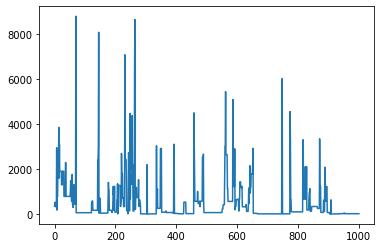

In [7]:
ga_a.run(1000)
ga_a.show_status()
plot_indices_to_sum(ga_a.best_indices_per_gen)
# plt.plot(ga_a.average_sum_per_gen)

generation_count 1000
average_sum 117189.28
best_sum 4
curr_best_sum 2751


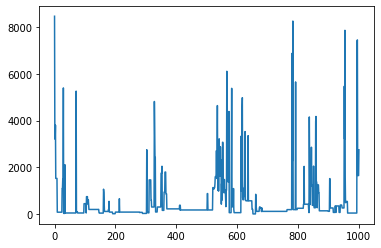

In [8]:
ga_b.run()
ga_b.show_status()
plot_indices_to_sum(ga_b.best_indices_per_gen)
# plt.plot(ga_b.average_sum_per_gen)

### Analiza mutation_ratio

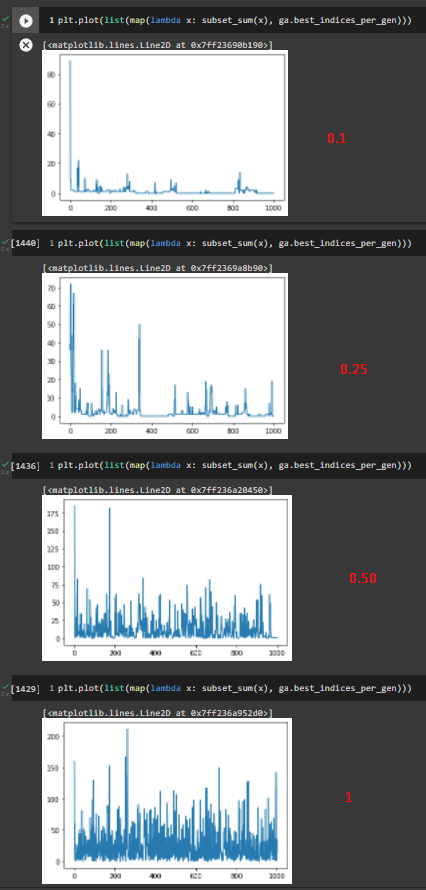

In [9]:
class GA_island:
  def __init__(self, island_count, migration_speed, migration_pause, *args):
    self.generation_count = 0
    self.islands = [GA(*args) for _ in range(island_count)]
    self.islad_count = island_count
    self.migration_speed = migration_speed
    self.migration_pause = migration_pause

  def migrate(self):
    for _ in range(self.migration_speed):
      emigrant = self.islands[-1].generation.pop()
      for ga in self.islands:
        ga.generation.add(emigrant)
        if ga != self.islands[-1]:
          emigrant = ga.generation.pop()

  def next_generations(self, n):
    end = False
    for _ in range(n):
      if end:
        break
      if self.generation_count % self.migration_pause == 0:
        self.migrate()
      for ga in self.islands:
        ga.next_generation()
        if ga.end_condition(ga):
          print('found solution:', ga.best_index)
          end = True
          break
      self.generation_count += 1

  def get_best_overall(self):
    best_arr = list(map(lambda ga: subset_sum(ga.best_index), self.islands))
    best_overall = min(best_arr)
    return best_overall

  def show_status(self):
    for i,ga in enumerate(self.islands):
      print(i)
      ga.show_status()
      print()

ga_islands = GA_island(10, 5, 10, 100, 0, 0.9, crossover_b, mutate_b, end_condition_a, fitness_function_a)
# list(map(lambda x: x.generation, ga_islands.islands))

In [10]:
ga_islands.next_generations(100)
# ga_islands.show_status()
print(ga_islands.generation_count)
ga_islands.get_best_overall()

found solution: 1000111011010111101011101100111011010011011001010011010110101100000110100011100001110101110110110110
21


0

In [18]:
limit = 100
times = 100

In [19]:
def test_cross_ratio(ratio):
  sums = []
  for x in range(times):
    ga = GA(100, 0.1, ratio, crossover_b, mutate_b, end_condition_a, fitness_function_a)
    result = ga.run(limit)
    sums.append(subset_sum(result))
    plot_indices_to_sum(ga.best_indices_per_gen)
  print('ratio: %0.2f - average sum after %d runs %d generations each:' % (ratio, times, limit), sum(sums)/len(sums))

ratio: 1.00 - average sum after 100 runs 100 generations each: 29.52


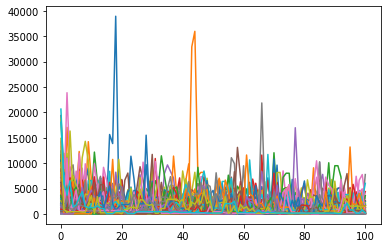

In [20]:
test_cross_ratio(1)

ratio: 0.75 - average sum after 100 runs 100 generations each: 51.1


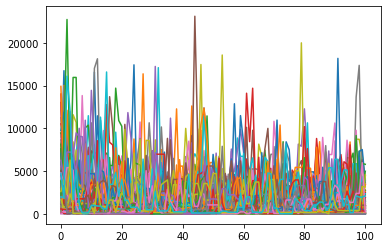

In [21]:
test_cross_ratio(0.75)

ratio: 0.50 - average sum after 100 runs 100 generations each: 56.18


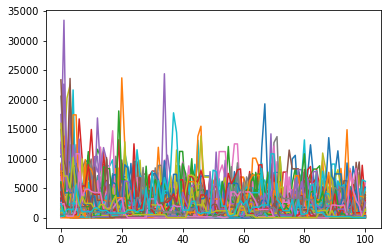

In [22]:
test_cross_ratio(0.5)

ratio: 0.25 - average sum after 100 runs 100 generations each: 99.75


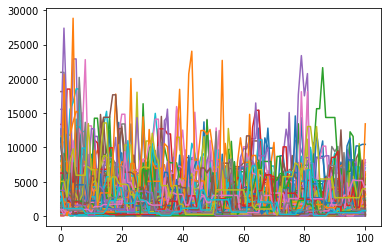

In [23]:
test_cross_ratio(0.25)

ratio: 0.00 - average sum after 100 runs 100 generations each: 409.41


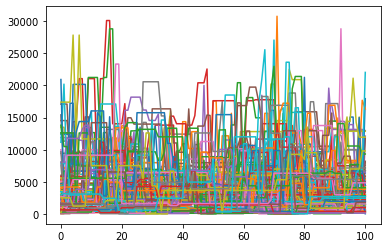

In [24]:
test_cross_ratio(0)